# Clusterização dos Prospectos de Fundos de Investimentos

## 1. Pipeline Tratamento Dados LLM

A classe abaixo: (i) carrega o dataframe com os dados extraídos via LLM, (ii) inclui coluna classificação ANBIMA, (iii) inclui historico cotacao bolsa, (iv) filtra por tipo de fundo e (v) integra dados LLM Kinea e Concorrência

In [0]:
!pip install yfinance pandas numpy 

  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/c9/1e/631c80e0f97aef46eb73549b9b0f60d94057294e040740f4cad0cb1f48e4/yfinance-0.2.65-py2.py3-none-any.whl.metadata
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for frozendict>=2.3.4 from https://files.pythonhosted.org/packages/04/13/d9839089b900fa7b479cce495d62110cddc4bd5630a04d8469916c0e79c5/frozendict-2.4.6-py311-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/949.2 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━ 757.8/949.2 kB 22.9 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.2/949.2 kB 13.6 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pypro

In [0]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import regexp_replace, to_date, when, col, coalesce, lit
import pandas as pd
import numpy as np
import yfinance as yf
from pyspark.sql.types import StringType, DateType, FloatType
from datetime import datetime, timedelta
from pyspark.sql import functions as F

class DataPipeline:
    def __init__(self, spark):
        self.spark = spark
        self.df = None
        self.taxa_rf_diaria = None  # para armazenar taxa SELIC diária

    def load_and_merge(self, df1: DataFrame, df2: DataFrame):
        if "tipo" in df1.columns:
            df1 = df1.withColumnRenamed("tipo", "tipo_fundo")
        if "tipo" in df2.columns:
            df2 = df2.withColumnRenamed("tipo", "tipo_fundo")
        self.df = df1.unionByName(df2)
        return self

    def standardize_columns(self):
        self.df = (
            self.df
            .withColumn("cnpj", regexp_replace("cnpj", "[^0-9]", ""))
            .withColumn("data_emissao", to_date("data_emissao", "yyyy-MM-dd"))
            .withColumn("tipo_fundo", when(col("tipo_fundo") == "F.I.I.", "FII").otherwise(col("tipo_fundo")))
        )
        return self

    def add_anbima_classification(self, anbima_table: str):
        df_anbima = (
            self.spark.table(anbima_table)
            .select(col("identificador_classe").alias("cnpj"), col("tipo_anbima"))
        )
        self.df = self.df.join(df_anbima, on="cnpj", how="left")
        return self

    def add_ticker(self, ticker_table: str):
        df_ticker = (
            self.spark.table(ticker_table)
            .select(col("Ticker"), col("CNPJ").alias("cnpj"))
            .withColumn("cnpj", regexp_replace("cnpj", "[^0-9]", ""))
        )
        self.df = self.df.join(df_ticker, on="cnpj", how="left")
        return self

    def drop_duplicates(self):
        self.df = self.df.dropDuplicates(["cnpj", "data_emissao"])
        return self

    def carregar_taxa_selic(self):
        """Busca taxa SELIC média diária do último ano."""
        hoje = datetime.today()
        inicio = hoje - timedelta(days=365)
        selic_url = (
            f"https://api.bcb.gov.br/dados/serie/bcdata.sgs.1178/dados"
            f"?formato=csv&dataInicial={inicio.strftime('%d/%m/%Y')}"
            f"&dataFinal={hoje.strftime('%d/%m/%Y')}"
        )
        try:
            selic_df = pd.read_csv(selic_url, sep=';', decimal=',', parse_dates=['data'], dayfirst=True)
            selic_df.columns = ['Data', 'SELIC']
            selic_df['SELIC'] = pd.to_numeric(selic_df['SELIC'], errors='coerce')
            selic_df.dropna(inplace=True)
            taxa_rf_anual = selic_df['SELIC'].mean() / 100
            self.taxa_rf_diaria = (1 + taxa_rf_anual) ** (1/252) - 1
        except Exception as e:
            print(f"[ERRO] Falha ao buscar SELIC: {e}")
            self.taxa_rf_diaria = 0.0  # fallback para evitar crash

    def calcular_metricas(self, ticker):
        if not isinstance(ticker, str) or ticker.strip() == '':
            return pd.Series([np.nan]*5, index=[
                'volatilidade_historica', 'liquidez_media', 'drawdown_max',
                'retorno_acumulado', 'sharpe_ratio'
            ])

        ticker_yf = ticker.strip()
        if not ticker_yf.endswith('.SA'):
            ticker_yf += ".SA"

        try:
            dados = yf.download(ticker_yf, period="1y", interval="1d", progress=False, auto_adjust=True)
            if dados.empty:
                return pd.Series([np.nan]*5, index=[
                    'volatilidade_historica', 'liquidez_media', 'drawdown_max',
                    'retorno_acumulado', 'sharpe_ratio'
                ])

            close = dados['Close']
            volume = dados['Volume']
            retorno_diario = close.pct_change().dropna()

            # garante float escalar
            volatilidade = float(retorno_diario.std() * np.sqrt(252))
            liquidez = float(volume.mean())
            retorno_acumulado = float((close.iloc[-1] / close.iloc[0]) - 1)
            drawdown_max = float(((close - close.cummax()) / close.cummax()).min())

            taxa_rf = float(self.taxa_rf_diaria or 0)
            excesso_retorno_diario = retorno_diario - taxa_rf
            sharpe_ratio = float((excesso_retorno_diario.mean() * 252) / volatilidade) if volatilidade != 0 else np.nan

            return pd.Series([
                volatilidade, liquidez, drawdown_max, retorno_acumulado, sharpe_ratio
            ], index=[
                'volatilidade_historica', 'liquidez_media', 'drawdown_max',
                'retorno_acumulado', 'sharpe_ratio'
            ])

        except Exception as e:
            print(f"[ERRO] Falha ao calcular métricas para {ticker_yf}: {e}")
            return pd.Series([np.nan]*5, index=[
                'volatilidade_historica', 'liquidez_media', 'drawdown_max',
                'retorno_acumulado', 'sharpe_ratio'
            ])

    def add_market_metrics(self):
        """Adiciona métricas de mercado para cada ticker (inclui Sharpe Ratio)."""
        # Pega SELIC uma vez só
        self.carregar_taxa_selic()

        tickers = [
            row['Ticker']
            for row in self.df.select('Ticker').filter(col("Ticker").isNotNull()).distinct().collect()
            if str(row['Ticker']).strip() != ''
        ]

        lista_metricas = []
        for t in tickers:
            serie = self.calcular_metricas(t)
            d = serie.to_dict()
            d['Ticker'] = t
            lista_metricas.append(d)

        df_metricas = pd.DataFrame(lista_metricas)
        for col_name in ['volatilidade_historica', 'liquidez_media', 'drawdown_max', 'retorno_acumulado', 'sharpe_ratio']:
            df_metricas[col_name] = df_metricas[col_name].astype(float)
        df_metricas['Ticker'] = df_metricas['Ticker'].astype(str)
        df_metricas = df_metricas.where(pd.notnull(df_metricas), None)

        df_metricas_spark = self.spark.createDataFrame(df_metricas)
        self.df = self.df.join(df_metricas_spark, on='Ticker', how='left')
        return self
    
    def add_valor_cotado_atual(self):
        """
        Calcula o valor cotado atual de cada fundo com Ticker
        e adiciona uma coluna 'valor_cotado_atual' no DataFrame.
        """

        # Lista de tickers únicos
        tickers = [
            row['Ticker']
            for row in self.df.select('Ticker').filter(col("Ticker").isNotNull()).distinct().collect()
            if str(row['Ticker']).strip() != ''
        ]

        # Busca valores cotados atuais
        lista_valores = []
        for t in tickers:
            ticker_yf = t.strip()
            if not ticker_yf.endswith(".SA"):
                ticker_yf += ".SA"
            try:
                dados = yf.download(ticker_yf, period="5d", interval="1d", progress=False, auto_adjust=True)
                if dados.empty:
                    valor_atual = None
                else:
                    valor_atual = float(dados['Close'].iloc[-1])
                lista_valores.append({"Ticker": t, "valor_cotado_atual": valor_atual})
            except Exception as e:
                print(f"[ERRO] Falha ao obter valor atual para {t}: {e}")
                lista_valores.append({"Ticker": t, "valor_cotado_atual": None})

        # Cria DataFrame Spark com valores cotados
        df_valores_spark = self.spark.createDataFrame(pd.DataFrame(lista_valores))

        # Faz join com o DataFrame principal
        self.df = self.df.join(df_valores_spark, on="Ticker", how="left")

        return self

    def filter_by_type(self, tipo):
        return self.df.filter(self.df["tipo_fundo"] == tipo)

    def get_df(self):
        return self.df
    
    def cast_fundo_columns(self):
        schema_cast = {
            "tipo_fundo": StringType(),
            "cnpj": StringType(),
            "data_emissao": DateType(),
            "qt_emissoes": FloatType(),
            "nome_fundo": StringType(),
            "valor_cota_emissao": FloatType(),
            "direito_preferencia_sobras_montante_adicional": StringType(),
            "taxa_distribuicao_emissao": FloatType(),
            "tabela_ativos_fundo": StringType(),
            "sumario_experiencia_socios": StringType(),
            "quantidade_cotas_emissao": FloatType(),
            "quantidade_cotas_adicionais_emissao": FloatType(),
            "publico_alvo": StringType(),
            "obs_publico_alvo": StringType(),
            "procuracao_AGE": StringType(),
            "planilha_custos": StringType(),
            "ordenar_fatores_risco": StringType(),
            "montante_minimo_emissao": FloatType(),
            "investimento_minimo_cpf_cnpj": FloatType(),
            "investimento_minimo_inst": FloatType(),
            'investimento_maximo_cpf_cnpj': FloatType(),
            'investimento_maximo_inst': FloatType(),
            'percentual_oferta_institucional': FloatType(),
            'volume_base_emissao': FloatType()
        }

        for col_name, dtype in schema_cast.items():
            if col_name in self.df.columns:
                self.df = self.df.withColumn(col_name, col(col_name).cast(dtype))

        if "quantidade_cotas_emissao" in self.df.columns and "quantidade_cotas_adicionais_emissao" in self.df.columns:
            self.df = self.df.withColumn(
                "quantidade_cotas_totais",
                coalesce(col("quantidade_cotas_emissao"), lit(0)) + coalesce(col("quantidade_cotas_adicionais_emissao"), lit(0))
            )
        return self
    
    def analisar_potencial_nova_emissao(self):
            """
            Para fundos com ticker, verifica se valor_cotado_atual > valor_cota_emissao.
            Adiciona coluna 'potencial_nova_emissao' (True/False).
            """
            self.df = self.df.withColumn(
                "potencial_nova_emissao",
                F.when(
                    (F.col("Ticker").isNotNull()) & (F.col("valor_cotado_atual") > F.col("valor_cota_emissao")),
                    True
                ).otherwise(False)
            )
            return self


Aplicando a classe para os tipos de fundos trabalhados (FIDC, FII e FIP):

In [0]:
from pyspark.sql.functions import lit

df1 = spark.table("desafio_kinea.prospecto_fundos.extracao_prospectos_kinea_v3")
df2 = spark.table("desafio_kinea.prospecto_fundos.extracao_prospectos_v3")

# adicionando colunas artificiais - alterar futuramente
df1 = df1.withColumn("tipo_gestor", lit("KINEA"))
df2 = df2.withColumn("tipo_gestor", lit("CONCORRENTE"))

pipeline = DataPipeline(spark)

df_final = (
    pipeline
    .load_and_merge(df1, df2)
    .standardize_columns()
    .cast_fundo_columns()
    .add_anbima_classification("desafio_kinea.prospecto_fundos.anbima_dev")
    .add_ticker("desafio_kinea.prospecto_fundos.mercado_fiis")
    .drop_duplicates()
    .add_market_metrics()
    .add_valor_cotado_atual()
    .analisar_potencial_nova_emissao()
    .get_df()  
)

df_fii = df_final.filter(col("tipo_fundo") == "FII")
df_fip = df_final.filter(col("tipo_fundo") == "FIP")
df_fidc = df_final.filter(col("tipo_fundo") == "FIDC")

ERROR:yfinance:HTTP Error 404: 
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['KPMR11.SA']: YFPricesMissingError('possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')
ERROR:yfinance:HTTP Error 404: 
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['KGUJ11.SA']: YFPricesMissingError('possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CAFE11.SA']: YFPricesMissingError('possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['KPMR11.SA']: YFPricesMissingError('possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['KGUJ11.SA']: YFPricesMissingError('possibly delisted; no price data found  (period=5d) (Yahoo er

In [0]:
display(df_fii)

Ticker,cnpj,data_emissao,qt_emissoes,nome_fundo,tipo_fundo,valor_cota_emissao,direito_preferencia_sobras_montante_adicional,taxa_distribuicao_emissao,tabela_ativos_fundo,sumario_experiencia_socios,quantidade_cotas_emissao,quantidade_cotas_adicionais_emissao,publico_alvo,obs_publico_alvo,procuracao_AGE,planilha_custos,ordenar_fatores_risco,montante_minimo_emissao,investimento_minimo_cpf_cnpj,investimento_minimo_inst,investimento_maximo_cpf_cnpj,investimento_maximo_inst,historico_cotacao_bolsa,fator_proporcao_dp,diluicao_economica_novas_emissoes,criterio_rateio,carteira_fundos_kinea_intrag,breve_historico_gestor,percentual_oferta_institucional,volume_base_emissao,chamada_capital_ipca,tipo_gestor,quantidade_cotas_totais,tipo_anbima,volatilidade_historica,liquidez_media,drawdown_max,retorno_acumulado,sharpe_ratio,valor_cotado_atual,potencial_nova_emissao
FTCE11,01235622000161,2015-07-13,4.0,OPPORTUNITY FUNDO DE INVESTIMENTO IMOBILIÁRIO,FII,1766.05,Não,null,"imóveis comerciais, residenciais, industriais, terrenos, shopping centers, títulos de renda fixa públicos e privados, cotas de fundos de investimento referenciados, renda fixa e curto prazo","Consultor Especializado MÉTRICA EMPREENDIMENTOS E PARTICIPAÇÕES LTDA., com 30 anos de experiência, coordenado por Jomar Monnerat, diretor com MBA em Finanças Corporativas pela FGV e experiência na KPMG e Grupo Opportunity",null,null,Investidores qualificados,,,Não incorrerá em custos adicionais para o Fundo,"Risco de Liquidez (Maior), Dificuldades Financeiras do Incorporador/Construtor (Maior), Risco relacionado a Fatores Macroeconômicos e Regulatórios (Maior), Riscos de Mercado (Maior), Risco de Crédito (Maior), Outros Riscos Exógenos ao Controle do Administrador (Maior), Risco de Desapropriação (Maior), Risco de Patrimônio Negativo (Maior), Riscos do Setor Imobiliário (Maior), Risco de Alterações nas Leis de Zoneamento (Maior), Riscos Ambientais (Maior), Riscos Relativos às Operações de Aquisição de bens Imóveis (Maior), Risco de Regularidade dos Imóveis (Maior), Riscos dos Contratos de Locação ou Arrendamento e Risco de Vacância (Maior), Risco de Desligamento da Carteira (Maior), Riscos quanto às Despesas de Manutenção dos Imóveis (Maior), Riscos decorrentes de Vícios Ocultos e Contingências Não Identificadas ou Não Identificáveis (Maior), Risco na gestão financeira, contábil e/ou imobiliária de empreendimento investido pelo FUNDO (Maior), Risco de Ocorrência de Casos Fortuitos e Eventos de Força Maior (Maior), Risco de sinistro e de perdas decorrentes de sinistros não cobertos pelos seguros contratados (Maior), Riscos Operacionais (Maior), Riscos de Conflitos de interesse (Maior), Risco de Custos Relativos a Eventuais Reclamações de Terceiros (Maior), Risco de concentração da carteira do FUNDO (Maior), Risco em Função da Dispensa de Registro da Oferta das Cotas do FUNDO (Maior), Risco do Bloqueio à Negociação de Cotas (Maior), Risco de Colocação Parcial da Emissão de Cotas (Maior), Risco de Governança (Maior), Risco de Inexistência de Garantia das Aplicações no FUNDO (Maior)",2.5E7,1000000.0,null,null,null,"Mín 1850 / Méd 1912.89 / Máx 2950 (2011), Mín 2950 / Méd 3106 / Máx 3350 (2012), Mín 3500 / Méd 3563.66 / Máx 3700.01 (2013), Mín 3710 / Méd 3710 / Máx 3710 (2014)",,,,,"BNY Mellon Serviços Financeiros, fundada em 1784, líder global em administração e gestão de ativos, com US$ 28,5 trilhões em ativos sob custódia e US$ 1,7 trilhão em ativos sob gestão até março de 2015",null,2.5E7,,CONCORRENTE,0.0,Multiestratégia Gestão Ativa,0.02800389511121603,29.72289156626506,-0.020245367891120653,0.008465619375751299,-3.993086313562455,2841.75,true
SHPH11,03507519000159,2007-04-16,4.0,Fundo de Investimento Imobiliário Shopping Pátio Higienópolis,FII,null,Sim,null,,,null,null,Público Geral,,,,,null,null,null,null,null,,,,,,,null,null,,CONCORRENTE,0.0,Tijolo Renda Gestão Definida,0.40875568778067195,246.2008032128514,-0.18277826942587097,0.23072085434129752,0.4238366818659527,970.1199951171875,fa

## 2. Modelo de Clusterização 

In [0]:
!pip install sentence-transformers

  Obtaining dependency information for sentence-transformers from https://files.pythonhosted.org/packages/6d/70/2b5b76e98191ec3b8b0d1dde52d00ddcc3806799149a9ce987b0d2d31015/sentence_transformers-5.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for transformers<5.0.0,>=4.41.0 from https://files.pythonhosted.org/packages/db/5a/022ac010bedfb5119734cf9d743cf1d830cb4c604f53bb1552216f4344dc/transformers-4.55.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/42.0 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.5 MB/s eta 0:00:00
  Obtaining dependency information for tqdm from https://files.pythonhosted.org/packages/d0/30/dc54f88dd4a2b5dc8a0279bdd7270e735851848b762aeb1c1184ed1f6b14/tqdm-4.67.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/57.7 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 3.2 MB/s eta 0:00:00
  Obtaining dependency information for torch>=1.11

In [0]:
from pyspark.sql.functions import col, coalesce, lit

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer
import warnings

# Suprime warnings específicos do threadpoolctl
warnings.filterwarnings("ignore", category=UserWarning, module='threadpoolctl')

class ClusterizadorFundos:
    def __init__(self, cols_numericas, cols_categoricas, modelo_embeddings='paraphrase-MiniLM-L6-v2'):
        # Inicializa atributos com listas de colunas e modelo de embeddings
        self.cols_numericas = cols_numericas
        self.cols_categoricas = cols_categoricas
        self.model = SentenceTransformer(modelo_embeddings)
        self.scaler = RobustScaler()
        self.pca = None
        self.kmeans = None
        self.embedding_cols = []
        self.df_final = None

    def _processar_categoricas(self, df_spark):
        """
        Processa as colunas categóricas do DataFrame Spark:
        - Seleciona as colunas categóricas e trata valores nulos.
        - Gera embeddings para cada coluna categórica usando SentenceTransformer.
        - Reduz a dimensionalidade dos embeddings com PCA.
        - Retorna um DataFrame pandas com as colunas de embeddings.
        """
        df_cat = df_spark.select('cnpj', 'data_emissao', 'tipo_fundo', *self.cols_categoricas)
        for col_name in self.cols_categoricas:
            df_cat = df_cat.withColumn(col_name, coalesce(col(col_name), lit('desconhecido')))
        df_cat_pd = df_cat.toPandas().drop_duplicates(subset=['cnpj', 'data_emissao'])

        embedding_cols_local = []
        # Gera embeddings para cada coluna categórica e reduz dimensionalidade com PCA
        for col_name in self.cols_categoricas:
            texts = df_cat_pd[col_name].astype(str).fillna('desconhecido').tolist()
            embeddings = self.model.encode(texts, batch_size=32, show_progress_bar=False)
            pca_emb = PCA(n_components=min(10, embeddings.shape[1]), random_state=42)
            emb_reduced = pca_emb.fit_transform(embeddings)
            for i in range(emb_reduced.shape[1]):
                col_emb_name = f'{col_name}_emb_{i}'
                df_cat_pd[col_emb_name] = emb_reduced[:, i]
                embedding_cols_local.append(col_emb_name)
        self.embedding_cols = embedding_cols_local

        # Retorna DataFrame sem as colunas categóricas originais
        return df_cat_pd.drop(columns=self.cols_categoricas)

    def preparar_dados(self, df_spark):
        """
        Prepara os dados para clusterização:
        - Preenche valores nulos e converte colunas numéricas para float.
        - Processa colunas categóricas e numéricas, mesclando ambas.
        - Normaliza os dados e aplica PCA para redução de dimensionalidade.
        - Retorna DataFrame mesclado e matriz reduzida pelo PCA.
        """
        df_spark = df_spark.fillna(0)
        for c in self.cols_numericas:
            df_spark = df_spark.withColumn(c, col(c).cast("float"))

        # Processa colunas categóricas e numéricas, mesclando ambas
        df_cat_pd = self._processar_categoricas(df_spark)
        df_num_pd = df_spark.select(['cnpj', 'data_emissao', 'tipo_fundo'] + self.cols_numericas).toPandas()
        df_merged = df_num_pd.merge(df_cat_pd, on=['cnpj', 'data_emissao', 'tipo_fundo'], how='left')

        # Preenche valores nulos nas colunas de interesse
        for col_name in self.cols_numericas + self.embedding_cols:
            if col_name in df_merged.columns:
                df_merged[col_name] = df_merged[col_name].fillna(0)

        # Normaliza os dados e aplica PCA para redução de dimensionalidade
        X = df_merged[self.cols_numericas + self.embedding_cols].values
        X_scaled = self.scaler.fit_transform(X)

        n_features = X_scaled.shape[1]
        if n_features < 2:
            n_components_pca = n_features
        else:
            n_components_pca = 0.9
        self.pca = PCA(n_components=n_components_pca, random_state=42)
        X_pca = self.pca.fit_transform(X_scaled)

        return df_merged, X_pca

    def escolher_k_automatico(self, X_pca, k_min=2, k_max=10, tipo_fundo=None):
        """
        Determina automaticamente o número ótimo de clusters (k):
        - Calcula SSE (inércia) e Silhouette Score para diferentes valores de k.
        - Plota gráficos do método do cotovelo e silhueta.
        - Retorna o valor de k considerado ótimo.
        """
        sse = []
        sil_scores = []
        k_range = range(k_min, k_max + 1)

        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(X_pca)
            sse.append(kmeans.inertia_)
            sil_scores.append(silhouette_score(X_pca, labels))

        # Plota gráficos do método do cotovelo e silhueta
        plt.figure(figsize=(12,5))
        plt.subplot(1, 2, 1)
        plt.plot(k_range, sse, marker='o')
        titulo_cotovelo = "Método do Cotovelo"
        if tipo_fundo:
            titulo_cotovelo += f" - {tipo_fundo}"
        plt.title(titulo_cotovelo)
        plt.xlabel("Número de Clusters (k)")
        plt.ylabel("SSE (Inércia)")

        plt.subplot(1, 2, 2)
        plt.plot(k_range, sil_scores, marker='o', color='orange')
        titulo_silhueta = "Coeficiente de Silhueta"
        if tipo_fundo:
            titulo_silhueta += f" - {tipo_fundo}"
        plt.title(titulo_silhueta)
        plt.xlabel("Número de Clusters (k)")
        plt.ylabel("Silhouette Score")
        plt.tight_layout()
        plt.show()

        # Define k ótimo com base nos métodos do cotovelo e silhueta
        k_otimo_inercia = k_range[np.argmin(np.gradient(np.gradient(sse)))]
        k_otimo_sil = k_range[np.argmax(sil_scores)]

        if k_otimo_inercia == k_otimo_sil:
            return k_otimo_inercia
        else:
            return round((k_otimo_inercia + k_otimo_sil) / 2)

    def aplicar_kmeans(self, df_merged, X_pca, k, tipo_fundo=None):
        """
        Aplica o algoritmo KMeans para clusterização:
        - Ajusta o modelo KMeans com o número de clusters k.
        - Adiciona colunas de identificação de cluster ao DataFrame.
        - Plota os clusters se houver mais de uma dimensão.
        - Retorna o DataFrame com os clusters atribuídos.
        """
        self.kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
        clusters = self.kmeans.fit_predict(X_pca)
        df_merged['cluster_id'] = clusters
        df_merged['cluster_id_full'] = df_merged['tipo_fundo'].astype(str) + "_" + df_merged['cluster_id'].astype(str)
        
        # Plota os clusters se houver mais de uma dimensão
        if X_pca.shape[1] > 1:
            plt.figure(figsize=(8,6))
            sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette='Set1', s=60)
            titulo_cluster = f"Clusters K-Means (k={k}) + PCA + Embeddings"
            if tipo_fundo:
                titulo_cluster += f" - {tipo_fundo}"
            plt.title(titulo_cluster)
            plt.xlabel("PC1")
            plt.ylabel("PC2")
            plt.legend(title='Cluster')
            plt.show()
        
        return df_merged

    def clusterizar_todos_tipos(self, df_spark, tipos, k_por_tipo=None):
        """
        Realiza a clusterização para cada tipo de fundo especificado:
        - Para cada tipo, prepara os dados, define k (manual ou automaticamente), aplica KMeans.
        - Retorna um dicionário com os resultados em pandas e Spark DataFrame para cada tipo.
        """
        resultados = {}
        for tipo in tipos:
            try:
                df_tipo = df_spark.filter(df_spark["tipo_fundo"] == tipo)
                df_merge, X_pca = self.preparar_dados(df_tipo)

                # Define k manualmente ou automaticamente
                if k_por_tipo and tipo in k_por_tipo:
                    k = k_por_tipo[tipo]
                else:
                    k = self.escolher_k_automatico(X_pca, tipo_fundo=tipo)

                df_result = self.aplicar_kmeans(df_merge, X_pca, k, tipo_fundo=tipo)
                resultados[tipo] = df_result

                # Adiciona cluster_id e cluster_id_full ao DataFrame Spark de cada tipo
                df_tipo_pd = df_result[['cnpj', 'data_emissao', 'cluster_id', 'cluster_id_full']]
                df_tipo_spark = df_tipo.join(
                    spark.createDataFrame(df_tipo_pd),
                    on=['cnpj', 'data_emissao'],
                    how='left'
                )
                resultados[f"{tipo}_spark"] = df_tipo_spark

            except Exception:
                continue

        return resultados

### 2.1. Parâmetros de Clusterização

In [0]:
# Lista de colunas numéricas relevantes para clusterização dos fundos
cols_num = [
    'valor_cota_emissao',                  # Valor da cota na emissão
    'taxa_distribuicao_emissao',           # Taxa de distribuição na emissão
    'quantidade_cotas_totais',             # Quantidade de cotas totais emitidas
    'investimento_minimo_cpf_cnpj',        # Investimento mínimo para CPF/CNPJ
    'investimento_minimo_inst',            # Investimento mínimo para institucionais
    'investimento_maximo_cpf_cnpj',        # Investimento máximo para CPF/CNPJ
    'investimento_maximo_inst',            # Investimento máximo para institucionais
    'percentual_oferta_institucional',     # Percentual da oferta para institucionais
    'montante_minimo_emissao',             # Montante mínimo da emissão
    'volume_base_emissao',                 # Volume base da emissão
    'chamada_capital_ipca',                # Chamada de capital indexada ao IPCA
    'volatilidade_historica', 
    'liquidez_media', 
    'drawdown_max', 
    'retorno_acumulado', 
    'sharpe_ratio'
]

# Lista de colunas categóricas relevantes para clusterização dos fundos
cols_cat = [
    'tabela_ativos_fundo',                 # Tabela de ativos do fundo
    'publico_alvo',                        # Público alvo do fundo
    'ordenar_fatores_risco',               # Fatores de risco ordenados
    'diluicao_economica_novas_emissoes',   # Diluição econômica em novas emissões
    'criterio_rateio',                     # Critério de rateio
    'tipo_anbima'                          # Tipo ANBIMA do fundo
]

### 2.2. Aplicando Classe de Cluster

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0a6d674720>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'
Ex

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

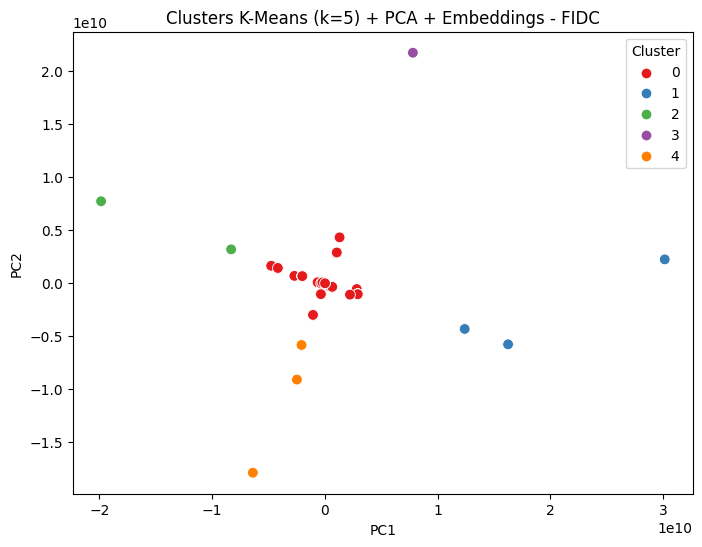

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0b91396840>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'
Ex

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

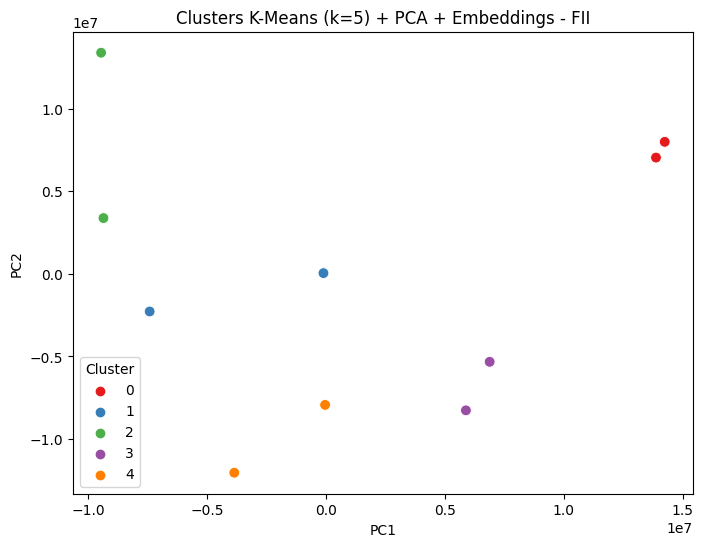

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0a50bae480>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'
Ex

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

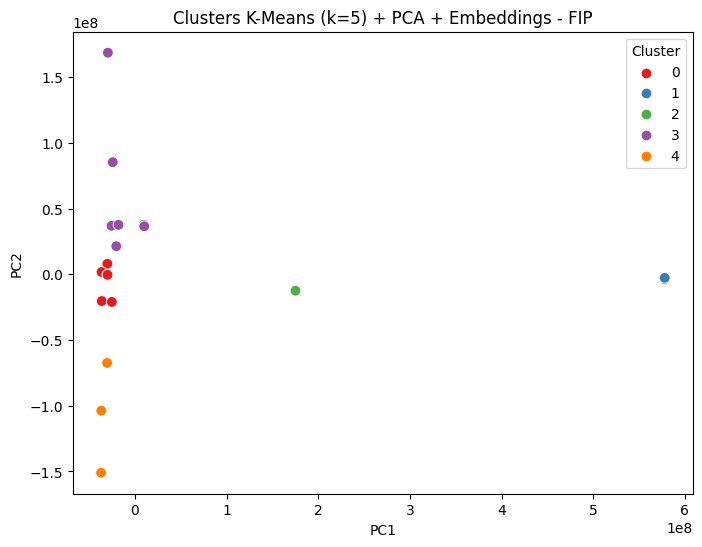

In [0]:
# Inicializa o clusterizador com colunas numéricas e categóricas
clusterizador = ClusterizadorFundos(cols_num, cols_cat)

# Define os tipos de fundos a serem clusterizados
tipos_fundos = ['FIDC', 'FII', 'FIP']

# Define manualmente o número de clusters para cada tipo de fundo (ajustado conforme Elbow e Silluette Methods)
# Caso contrário, o modelo define automaticamente a média das metodologias
k_manual = {'FII': 5, 'FIDC': 5, 'FIP': 5}

# Realiza a clusterização para cada tipo de fundo usando os valores de k definidos
resultados = clusterizador.clusterizar_todos_tipos(df_final, tipos_fundos, k_por_tipo=k_manual)

In [0]:
for tipo in tipos_fundos:
    print(f'Visualizando: {tipo}')
    display(resultados[tipo])

Visualizando: FIDC


cnpj,data_emissao,tipo_fundo,valor_cota_emissao,taxa_distribuicao_emissao,quantidade_cotas_totais,investimento_minimo_cpf_cnpj,investimento_minimo_inst,investimento_maximo_cpf_cnpj,investimento_maximo_inst,percentual_oferta_institucional,montante_minimo_emissao,volume_base_emissao,chamada_capital_ipca,volatilidade_historica,liquidez_media,drawdown_max,retorno_acumulado,sharpe_ratio,tabela_ativos_fundo_emb_0,tabela_ativos_fundo_emb_1,tabela_ativos_fundo_emb_2,tabela_ativos_fundo_emb_3,tabela_ativos_fundo_emb_4,tabela_ativos_fundo_emb_5,tabela_ativos_fundo_emb_6,tabela_ativos_fundo_emb_7,tabela_ativos_fundo_emb_8,tabela_ativos_fundo_emb_9,publico_alvo_emb_0,publico_alvo_emb_1,publico_alvo_emb_2,publico_alvo_emb_3,publico_alvo_emb_4,publico_alvo_emb_5,publico_alvo_emb_6,publico_alvo_emb_7,publico_alvo_emb_8,publico_alvo_emb_9,ordenar_fatores_risco_emb_0,ordenar_fatores_risco_emb_1,ordenar_fatores_risco_emb_2,ordenar_fatores_risco_emb_3,ordenar_fatores_risco_emb_4,ordenar_fatores_risco_emb_5,ordenar_fatores_risco_emb_6,ordenar_fatores_risco_emb_7,ordenar_fatores_risco_emb_8,ordenar_fatores_risco_emb_9,diluicao_economica_novas_emissoes_emb_0,diluicao_economica_novas_emissoes_emb_1,diluicao_economica_novas_emissoes_emb_2,diluicao_economica_novas_emissoes_emb_3,diluicao_economica_novas_emissoes_emb_4,diluicao_economica_novas_emissoes_emb_5,diluicao_economica_novas_emissoes_emb_6,diluicao_economica_novas_emissoes_emb_7,diluicao_economica_novas_emissoes_emb_8,diluicao_economica_novas_emissoes_emb_9,criterio_rateio_emb_0,criterio_rateio_emb_1,criterio_rateio_emb_2,criterio_rateio_emb_3,criterio_rateio_emb_4,criterio_rateio_emb_5,criterio_rateio_emb_6,criterio_rateio_emb_7,criterio_rateio_emb_8,criterio_rateio_emb_9,tipo_anbima_emb_0,tipo_anbima_emb_1,tipo_anbima_emb_2,tipo_anbima_emb_3,tipo_anbima_emb_4,tipo_anbima_emb_5,tipo_anbima_emb_6,tipo_anbima_emb_7,tipo_anbima_emb_8,tipo_anbima_emb_9,cluster_id,cluster_id_full
06018364000185,2006-06-30,FIDC,1.0,0.0,0.0,25000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.5168539,-0.6665648,-1.2053424,-0.3149356,-0.17449318,0.6338917,-0.7251467,-0.10393893,0.32636124,0.18174028,-1.6294063,-0.019865626,-0.18402731,-0.010968602,0.06601892,-0.008971493,-0.09154479,-6.035168E-4,-0.05976475,-0.036405597,-0.75635564,0.1160473,0.08017444,0.7166814,0.39102134,0.910561,-0.18903065,-0.15171945,-0.023316331,-0.45814154,-0.32641047,-6.994614E-4,-0.0010106632,-7.010395E-4,1.2747722E-4,-1.4655115E-4,1.1913554E-5,-1.1801965E-5,-7.0725305E-6,-3.1684634E-5,-1.060373,0.038552277,-0.009564646,-0.037270218,-0.009195416,-0.0073745367,0.002047579,-5.6327204E-4,6.856935E-4,-4.1028576E-5,5.7305512,-1.0425903,-0.20611425,-0.007966321,-0.008033827,0.005176131,6.623321E-6,-6.293347E-6,1.0518776E-10,1.5016883E-12,0,FIDC_0
06018364000185,2007-04-24,FIDC,1.0,0.0,0.0,25000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.5168568,-0.66656435,-1.2053428,-0.31493494,-0.17449363,0.6338924,-0.72514683,-0.10393971,0.32636097,0.18174152,-1.6294038,-0.01986655,-0.18402554,-0.010968081,0.066018015,-0.008972354,-0.09154494,-6.036066E-4,-0.05976532,-0.036405697,-0.58323365,0.28229788,0.40293154,0.24397212,-0.55833757,0.69440013,-0.52605706,0.29329556,-0.0999868,0.24606682,-0.32640937,-6.9975056E-4,-0.0010104869,-7.0039154E-4,1.2597036E-4,-1.46758E-4,1.2800884E-5,-1.164274E-5,-6.794988E-6,-3.1235642E-5,-1.0603658,0.03855273,-0.009564261,-0.037272453,-0.009195793,-0.0073737833,0.0020468044,-5.636894E-4,6.865487E-4,-4.0999483E-5,5.730547,-1.0425907,-0.20611165,-0.007968398,-0.0080366945,0.0051753903,6.1361393E-6,-4.1084792E-7,-1.597319E-7,-6.6389366E-6,0,FIDC_0
06018364000185,2009-06-04,FIDC,1.0,0.0,0.0,25000.0,0.0,0.0,0.0,0.0,25000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.5168568,-0.6665659,-1.2053405,-0.3149351,-0.17449239,0.63389254,-0.72514594,-0.103938274,0.3263616,0.18173926,-1.6294065,-0.019864451,-0.18402629,-0.010968678,0.06601903,-0.008971841,-0.091545664,-6.0264405E-4,-0.059766233,-0.036406312,-0.58323586,0.28229642,0.4029328,0

Visualizando: FII


cnpj,data_emissao,tipo_fundo,valor_cota_emissao,taxa_distribuicao_emissao,quantidade_cotas_totais,investimento_minimo_cpf_cnpj,investimento_minimo_inst,investimento_maximo_cpf_cnpj,investimento_maximo_inst,percentual_oferta_institucional,montante_minimo_emissao,volume_base_emissao,chamada_capital_ipca,volatilidade_historica,liquidez_media,drawdown_max,retorno_acumulado,sharpe_ratio,tabela_ativos_fundo_emb_0,tabela_ativos_fundo_emb_1,tabela_ativos_fundo_emb_2,tabela_ativos_fundo_emb_3,tabela_ativos_fundo_emb_4,tabela_ativos_fundo_emb_5,tabela_ativos_fundo_emb_6,tabela_ativos_fundo_emb_7,tabela_ativos_fundo_emb_8,tabela_ativos_fundo_emb_9,publico_alvo_emb_0,publico_alvo_emb_1,publico_alvo_emb_2,publico_alvo_emb_3,publico_alvo_emb_4,publico_alvo_emb_5,publico_alvo_emb_6,publico_alvo_emb_7,publico_alvo_emb_8,publico_alvo_emb_9,ordenar_fatores_risco_emb_0,ordenar_fatores_risco_emb_1,ordenar_fatores_risco_emb_2,ordenar_fatores_risco_emb_3,ordenar_fatores_risco_emb_4,ordenar_fatores_risco_emb_5,ordenar_fatores_risco_emb_6,ordenar_fatores_risco_emb_7,ordenar_fatores_risco_emb_8,ordenar_fatores_risco_emb_9,diluicao_economica_novas_emissoes_emb_0,diluicao_economica_novas_emissoes_emb_1,diluicao_economica_novas_emissoes_emb_2,diluicao_economica_novas_emissoes_emb_3,diluicao_economica_novas_emissoes_emb_4,diluicao_economica_novas_emissoes_emb_5,diluicao_economica_novas_emissoes_emb_6,diluicao_economica_novas_emissoes_emb_7,diluicao_economica_novas_emissoes_emb_8,diluicao_economica_novas_emissoes_emb_9,criterio_rateio_emb_0,criterio_rateio_emb_1,criterio_rateio_emb_2,criterio_rateio_emb_3,criterio_rateio_emb_4,criterio_rateio_emb_5,criterio_rateio_emb_6,criterio_rateio_emb_7,criterio_rateio_emb_8,criterio_rateio_emb_9,tipo_anbima_emb_0,tipo_anbima_emb_1,tipo_anbima_emb_2,tipo_anbima_emb_3,tipo_anbima_emb_4,tipo_anbima_emb_5,tipo_anbima_emb_6,tipo_anbima_emb_7,tipo_anbima_emb_8,tipo_anbima_emb_9,cluster_id,cluster_id_full
01235622000161,2015-07-13,FII,1766.05,0.0,0.0,1000000.0,0.0,0.0,0.0,0.0,2.5E7,2.5E7,0.0,0.028003896,29.72289,-0.020245368,0.00846562,-3.9930863,-2.0876806,-1.4425852,-0.9849481,-0.1240158,-0.8183905,0.858564,0.67424935,0.052425224,2.0581305,1.2676318,-1.396127,-2.796336,-0.9396906,0.08052648,0.031040376,0.005900774,0.0050865742,0.01919982,3.9490544E-7,4.5215728E-7,-0.25917172,0.46807867,-0.5000917,0.83354706,-0.09865383,-0.023618953,-0.15335786,0.1967302,0.23057143,-0.1959733,-2.76715,-0.017302843,0.023647703,0.0065821633,0.004590405,0.004381575,-3.8487677E-4,4.844689E-4,-2.3008723E-4,5.733058E-7,4.21795,-1.1695371,-0.025245948,-0.07457303,0.013831816,5.276546E-7,3.6560226E-7,2.7546815E-7,1.2140198E-7,4.1371393E-8,3.9948761,-1.5669683,0.41745582,-0.21594465,-0.017341333,5.273624E-7,5.918852E-7,6.93894E-8,-5.015343E-8,-3.873314E-8,1,FII_1
03507519000159,2007-04-16,FII,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4087557,246.2008,-0.18277827,0.23072085,0.42383668,4.683354,-0.12643963,-0.05717792,-0.025523867,-0.07150784,-0.04004219,0.031466328,-0.021914229,0.006007428,-0.010848687,2.404256,3.3316,-3.2272553,4.229533,-0.18374108,-0.3046504,-0.09374521,-0.0321776,5.815983E-7,2.1997805E-7,6.5093975,-1.3246478,-0.10249971,0.022813506,0.08008892,-0.016707752,0.04595754,0.009927067,0.030071734,0.014792881,-2.7671494,-0.017303243,0.023647808,0.006582669,0.004590353,0.004381336,-3.8493995E-4,4.8434758E-4,-2.3012403E-4,3.992464E-7,4.2179484,-1.1695374,-0.025246007,-0.07457338,0.013832444,5.4762364E-7,-1.0971737E-7,-2.3839965E-7,1.19749615E-8,1.3887241E-7,-2.6981413,-0.9854133,-0.13292937,-0.5387962,0.083872885,5.84055E-7,3.566598E-7,2.638119E-8,-3.0201428E-9,-6.2674914E-9,1,FII_1
03683056000186,2011-11-01,FII,1.7,0.0,2.9411764E7,100.0,500000.0,0.0,0.0,0.0,5000000.0,5.0E7,0.0,0.29667792,7598.044,-0.15738787,0.027917773,-0.16511928,-1.7126001,-1.5483253,-1.0645372,0.6721175,-0.8297405,0.025818145,-1.3538771,1.7278913,-1.0585719,0.88455015,-1.9719892,2.1072886,0.595631,0.3073571,0.16284361,2.50836,-0.6920654,0.22523238,5.8159736E-7,2.1

Visualizando: FIP


cnpj,data_emissao,tipo_fundo,valor_cota_emissao,taxa_distribuicao_emissao,quantidade_cotas_totais,investimento_minimo_cpf_cnpj,investimento_minimo_inst,investimento_maximo_cpf_cnpj,investimento_maximo_inst,percentual_oferta_institucional,montante_minimo_emissao,volume_base_emissao,chamada_capital_ipca,volatilidade_historica,liquidez_media,drawdown_max,retorno_acumulado,sharpe_ratio,tabela_ativos_fundo_emb_0,tabela_ativos_fundo_emb_1,tabela_ativos_fundo_emb_2,tabela_ativos_fundo_emb_3,tabela_ativos_fundo_emb_4,tabela_ativos_fundo_emb_5,tabela_ativos_fundo_emb_6,tabela_ativos_fundo_emb_7,tabela_ativos_fundo_emb_8,tabela_ativos_fundo_emb_9,publico_alvo_emb_0,publico_alvo_emb_1,publico_alvo_emb_2,publico_alvo_emb_3,publico_alvo_emb_4,publico_alvo_emb_5,publico_alvo_emb_6,publico_alvo_emb_7,publico_alvo_emb_8,publico_alvo_emb_9,ordenar_fatores_risco_emb_0,ordenar_fatores_risco_emb_1,ordenar_fatores_risco_emb_2,ordenar_fatores_risco_emb_3,ordenar_fatores_risco_emb_4,ordenar_fatores_risco_emb_5,ordenar_fatores_risco_emb_6,ordenar_fatores_risco_emb_7,ordenar_fatores_risco_emb_8,ordenar_fatores_risco_emb_9,diluicao_economica_novas_emissoes_emb_0,diluicao_economica_novas_emissoes_emb_1,diluicao_economica_novas_emissoes_emb_2,diluicao_economica_novas_emissoes_emb_3,diluicao_economica_novas_emissoes_emb_4,diluicao_economica_novas_emissoes_emb_5,diluicao_economica_novas_emissoes_emb_6,diluicao_economica_novas_emissoes_emb_7,diluicao_economica_novas_emissoes_emb_8,diluicao_economica_novas_emissoes_emb_9,criterio_rateio_emb_0,criterio_rateio_emb_1,criterio_rateio_emb_2,criterio_rateio_emb_3,criterio_rateio_emb_4,criterio_rateio_emb_5,criterio_rateio_emb_6,criterio_rateio_emb_7,criterio_rateio_emb_8,criterio_rateio_emb_9,tipo_anbima_emb_0,tipo_anbima_emb_1,tipo_anbima_emb_2,tipo_anbima_emb_3,tipo_anbima_emb_4,tipo_anbima_emb_5,tipo_anbima_emb_6,tipo_anbima_emb_7,tipo_anbima_emb_8,tipo_anbima_emb_9,cluster_id,cluster_id_full
08954286000156,2007-08-20,FIP,100.0,0.0,0.0,100000.0,0.0,0.0,0.0,0.0,300000.0,6.0E7,0.0,0.0,0.0,0.0,0.0,0.0,-1.649214,0.30249465,-0.4693563,-0.0061793737,-0.20811923,-0.32017857,-0.6896751,0.07910909,0.009036917,-0.44815353,1.4955769,0.4938882,0.09038612,0.19454981,2.2115283,0.16819784,-0.14974414,0.3402196,-0.0878555,-0.36310527,-1.1639856,2.9369707,-0.8304546,-0.9285111,0.81631863,-0.52397937,0.3521273,-0.13361685,0.5804091,-0.26663044,-1.1378586,-0.021309696,-0.014458802,-7.04748E-4,0.015729876,0.0017537279,0.002552493,6.2223687E-4,1.6275401E-6,-1.1523457E-6,-1.9502252,-0.30903158,-0.05815081,-0.008437999,0.018015495,0.0011881004,4.1174694E-4,9.2400203E-4,-2.967413E-4,2.0196028E-6,-0.6723053,2.2326628E-6,2.914882E-7,-4.2082834E-7,7.757222E-7,1.9854065E-7,2.2589389E-13,-4.2715186E-13,-3.6406829E-13,1.2025881E-13,0,FIP_0
08991641000167,2007-11-09,FIP,1.0,0.0,4.3E8,100000.0,0.0,0.0,0.0,0.0,1.0E8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.361972,0.04228518,-0.08884849,-0.03147564,-0.040177982,-8.3835935E-4,-0.010914422,-0.019222995,-0.0013313642,0.008966388,-2.0332165,0.27058607,-0.25133675,-0.06514537,-0.1253447,0.1112234,8.0065324E-4,0.054578748,-0.05990937,0.07517596,-0.4416357,-1.2200967,1.2044052,0.9346758,2.1001494,-0.5721602,-0.45892856,0.506359,-0.53528214,0.32563388,-1.1378611,-0.021310303,-0.014458351,-7.047348E-4,0.015729608,0.0017537765,0.00255255,6.221771E-4,1.5840359E-6,-1.231008E-6,-1.9502289,-0.3090321,-0.058150634,-0.0084378105,0.01801536,0.00118788,4.1177432E-4,9.23914E-4,-2.9667577E-4,2.0190394E-6,-0.67230535,2.2294648E-6,-1.7758396E-8,-1.2257643E-9,7.4467366E-9,-1.0679667E-7,-4.874632E-7,5.4533683E-7,4.8432645E-7,2.5514982E-8,0,FIP_0
08991641000167,2008-02-01,FIP,1.0,0.0,4.3E8,100000.0,0.0,0.0,0.0,0.0,1.0E8,4.3E8,0.0,0.0,0.0,0.0,0.0,0.0,-1.6622096,-1.0903889,-0.3212299,1.0044609,-1.194003,0.6907633,-0.07155066,-0.66813546,0.33396626,-0.17483936,-2.0332158,0.2705843,-0.2513374,-0.06514535,-0.12534368,0.11122312,8.0056017E-4,0.05457827,-0.059908792,0.07517614,-0.33760512,-1.1231943,0.21343362,1.2056725,1.2881914,-0.346

In [0]:
# Salvando os resultados no Schema

from pyspark.sql.functions import col

def select_cluster_cols(df_cluster):
    """Seleciona apenas as colunas relevantes para o join de clusters."""
    return df_cluster.select("cnpj", "data_emissao", "cluster_id", "cluster_id_full")

def bind_clusters(df_base, df_cluster):
    """Faz join entre o DataFrame base e o de clusterização."""
    return df_base.join(
        select_cluster_cols(df_cluster),
        on=["cnpj", "data_emissao"],
        how="left"
    )

# Lista de tipos de fundo a serem processados
tipos_fundos = ['FIDC', 'FII', 'FIP']

dfs_bind = {}
for tipo in tipos_fundos:
    # Recupera o DataFrame base para o tipo de fundo
    df_base = globals()[f"df_{tipo.lower()}"]
    # Recupera o DataFrame de clusters para o tipo de fundo
    df_cluster = resultados[f"{tipo}_spark"]

    # Realiza o join entre o DataFrame base e o de clusters
    df_bind = bind_clusters(df_base, df_cluster)
    dfs_bind[tipo] = df_bind

    # Cria variável global para o DataFrame resultante do join
    globals()[f"df_{tipo.lower()}_bind"] = df_bind

    # Salva o DataFrame resultante no schema especificado, substituindo se já existir
    tabela = f"desafio_kinea.prospecto_fundos.resultados_cluster_{tipo.lower()}"
    df_bind.write.mode("overwrite").option("overwriteSchema", "true").saveAsTable(tabela)